In [42]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
words = stopwords.words("english")
stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pishi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pishi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
stopwords_set = set(stopwords.words("english"))
df = pd.read_csv('1429_1.csv', keep_default_na=False, skip_blank_lines=False)
df = df.replace(np.nan, '', regex=True)

C:\Users\pishi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
df['newComments'] = df[['reviews.text', 'reviews.title']].apply(lambda x: ' '.join(x), axis=1)
df['newComments'] = df['reviews.text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords_set]).lower())
TVec = TfidfVectorizer(sublinear_tf=True, min_df=6, stop_words='english')
ch2 = SelectPercentile(chi2, percentile=9.5)
X_text_processing = TVec.fit_transform(df['newComments'])

#df['reviews.rating'].astype(str).astype(int).astype(float)
#df['reviews.rating'].convert_objects(convert_numeric=True)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'],errors='coerce')

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df[['reviews.rating']])
df['reviews.rating']=imp.transform(df[['reviews.rating']]).ravel()
'''
imputed_DF = pd.DataFrame(imp.fit_transform(df.loc[:, 14]))
imputed_DF.columns = df.columns
imputed_DF.index = df.index
'''
y_text_processing = df['reviews.rating'].astype(np.int64)

In [45]:
df['newComments']

0        this product far disappoint my children love u...
1           great beginn experienc person bought gift love
2        inexpens tablet use learn step nabi he thrill ...
3        i fire hd two week i love this tablet great va...
4        i bought grand daughter come visit i set user ...
5        this amazon fire inch tablet perfect size i pu...
6        great e read go nice light weight price point ...
7        i gave christma gift inlaw husband uncl they l...
8        great devic read book i like link borrow libra...
9                            i love order book read reader
10                         not easi elder user ceas ad pop
11       excel product easi use larg screen make watch ...
12       want father first tablet good valu he watch mo...
13       simpli everyth i need thank youand silk work w...
14                            got present love size screen
15       the kindl easiest use graphic screen crisp cle...
16       nice reader almost perfect want need good barga

In [108]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array
vect = CountVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, min_df=6,  max_features=5000)
label_encoder_y = LabelEncoder()
y_recommended = df['reviews.doRecommend']


#df['reviews.doRecommend'].eq('TRUE').mul(1)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 1 if x == "TRUE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == "FALSE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].replace(np.nan, '', regex=True)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == '' else x)

#print(onehot_encoded)
y_keras = df['reviews.doRecommend']


X_train_kera, X_test_kera, y_train_kera, y_test_kera = train_test_split(df['newComments'], y_keras, test_size=0.2)
X_train_onehot = vect.fit_transform(X_train_kera)
X_test_onehot = vect.transform(X_test_kera)

In [112]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors = 2)
neigh.fit(X_train_onehot, y_train_kera)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [113]:
print(neigh.predict(X_test_onehot))

[1.  0.5 1.  ... 0.  1.  1. ]


In [119]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

RSME_values = []
for k in range(10):
    k += 1
    
    neigh = KNeighborsRegressor(n_neighbors = k)
    neigh.fit(X_train_onehot, y_train_kera)
    y_pred = neigh.predict(X_test_onehot)
    err = sqrt(mean_squared_error(y_pred, y_test_kera))
    RSME_values.append(err)
    print('RSME value for k = ', k , 'is:', err)

RSME value for k =  1 is: 0.47802246999845893
RSME value for k =  2 is: 0.43151091921147317
RSME value for k =  3 is: 0.4232079348042729
RSME value for k =  4 is: 0.3719097522517598
RSME value for k =  5 is: 0.3687755194256256
RSME value for k =  6 is: 0.36483218020801
RSME value for k =  7 is: 0.3629606112747995
RSME value for k =  8 is: 0.3626581524196657
RSME value for k =  9 is: 0.3620291298570495
RSME value for k =  10 is: 0.3625003730821647


Text(0,0.5,'RSME Value')

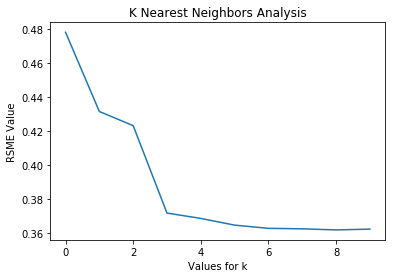

In [127]:
plt.plot(RSME_values)
plt.title("K Nearest Neighbors Analysis")
plt.xlabel('Values for k')
plt.ylabel('RSME Value')